# Part 1

In [1]:
import numpy as np                            # numpy for numerical computation
import torch                                  # Torch for Pytorch base (for deep learning)
import torchvision                            # TorchVision for image processing
import matplotlib.pyplot as plt               # Plotting tools
from time import time                         # Timing tools
from torchvision import datasets, transforms  # Import dataset and transform functions
from torch import nn, optim                   # Import neural network and optimization classes
import cv2                                    # Import computer vision tools
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform is a global class object that does the transform for you.

In [3]:
# Download the training data and the validation data
trainset    = datasets.MNIST('C:/Users/Stanley Chan/Dropbox/Python/ColorSpace/', download=True, train=True, transform=transform)
valset      = datasets.MNIST('C:/Users/Stanley Chan/Dropbox/Python/ColorSpace/', download=True, train=False, transform=transform)
testset     = datasets.MNIST(root = 'data', train = False, download=True, transform=transform)

# Define the loader that loads images into the correct format
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader   = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True)

# Create iteration objection, images, and labels
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [4]:
def validation(model, valid_loader, criterion):
    # Settings
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for data,labels in valid_loader:
            inputs = data.view(data.shape[0], -1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_total += loss.item()

    return loss_total / len(valid_loader)

# Part 4 Construct Your Model

In [5]:
# Here we construct the neural network. There is no training involved yet. We are only defining the model.
input_size = 784
hidden_sizes = [128, 64, 32]
output_size = 10
input_layer = nn.Linear(input_size, hidden_sizes[0])
hidden_layer1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
hidden_layer2 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
output_layer = nn.Linear(hidden_sizes[2], output_size)

model = nn.Sequential(input_layer,
                      nn.ReLU(),
                      hidden_layer1,
                      nn.ReLU(),
                      hidden_layer2,
                      nn.ReLU(),
                      output_layer,
                      nn.LogSoftmax(dim=1))

nn.init.xavier_normal_(input_layer.weight)
nn.init.xavier_normal_(hidden_layer1.weight)
nn.init.xavier_normal_(hidden_layer2.weight)
nn.init.xavier_normal_(output_layer.weight)

Parameter containing:
tensor([[ 4.4027e-01,  2.5405e-01,  2.6630e-01,  2.6577e-01, -2.7963e-01,
          9.0584e-02,  4.7563e-01, -2.7185e-01, -2.1006e-01,  3.5336e-03,
          2.7866e-02,  3.1610e-02,  4.3082e-01, -6.7518e-02, -3.9658e-04,
          1.4873e-01, -9.3950e-02, -1.9951e-01, -6.5934e-02,  5.9969e-02,
         -2.7129e-01, -2.0931e-01, -1.5509e-01,  8.0420e-02, -1.1546e-01,
         -4.1617e-01, -2.0517e-01, -7.2981e-02, -1.5172e-02, -2.0395e-01,
          2.1389e-01,  6.8967e-02],
        [-2.2181e-02,  2.3653e-02, -1.3756e-02,  2.3385e-01,  1.6943e-01,
         -1.1315e-01,  1.7748e-01, -1.7383e-01, -4.3972e-01,  2.7963e-01,
          8.7452e-02,  2.6875e-01,  3.3589e-01,  2.3996e-02, -1.5436e-01,
          7.5931e-02, -1.1091e-01,  8.8540e-02,  3.5508e-01, -4.6693e-02,
         -5.4696e-02,  1.9362e-01, -2.1720e-02,  1.0231e-01, -4.6435e-02,
          4.1029e-03,  8.3697e-02,  1.1606e-01,  1.5666e-01,  1.1782e-02,
          9.8550e-02, -1.9211e-01],
        [-5.4353e-

# Part 5 Construct the training loss

In [6]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)                 #log probabilities
loss = criterion(logps, labels)       #calculate the NLL loss

# Part 6 Main Training Loop

In [7]:
x = []
cost = []
cost_val = []

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, maximize=False)

time0 = time()
epochs = 50

# Early stopping
the_last_loss = 100
patience = 2
trigger_times = 0

for e in range(epochs):
    running_loss = 0
    x.append(e+1)
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        # Early stopping
        the_current_loss = validation(model, valloader, criterion)
        print('The current loss:', the_current_loss)
        
        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                print("\nTraining Time (in minutes) =",(time()-time0)/60)
                print("hardswish with early stopping")
                the_last_loss = the_current_loss  
                cost_val.append(the_last_loss)
                cost.append(running_loss/len(trainloader))
                break
        else:
            print('trigger times: 0')
            trigger_times = 0
        
        the_last_loss = the_current_loss  
        cost_val.append(the_last_loss)
        cost.append(running_loss/len(trainloader))
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        
print("\nTraining Time (in minutes) =",(time()-time0)/60)
print("epochs = ", x)
print("train = ", cost)
print("test = ", cost_val)

The current loss: 0.1912450728475288
trigger times: 0
Epoch 0 - Training loss: 0.34408657471023835
The current loss: 0.14729561596207177
trigger times: 0
Epoch 1 - Training loss: 0.16522126659345843
The current loss: 0.14017954093232088
trigger times: 0
Epoch 2 - Training loss: 0.13020950312346918
The current loss: 0.11947528335449707
trigger times: 0
Epoch 3 - Training loss: 0.10773993063785596
The current loss: 0.10092684921695833
trigger times: 0
Epoch 4 - Training loss: 0.09745935246751491
The current loss: 0.11011650597166484
trigger times: 1
Epoch 5 - Training loss: 0.08380990693651473
The current loss: 0.10467809549930274
trigger times: 0
Epoch 6 - Training loss: 0.07654690972245387
The current loss: 0.08748714530552815
trigger times: 0
Epoch 7 - Training loss: 0.06998022886187728
The current loss: 0.09487199410128816
trigger times: 1
Epoch 8 - Training loss: 0.06358513312237059
The current loss: 0.11275946571206923
trigger times: 2
Early stopping!
Start to test process.

Traini

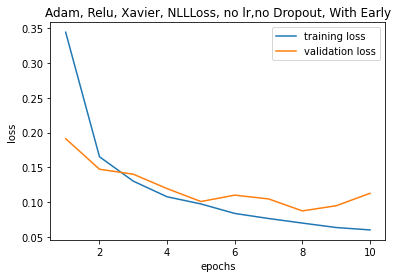

In [8]:
plt.plot(x,cost,x, cost_val)
plt.title("Adam, Relu, Xavier, NLLLoss, no lr,no Dropout, With Early")
plt.legend(["training loss","validation loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Part 7 Testing
(This code uses the validation dataset)

Predicted Digit = 7


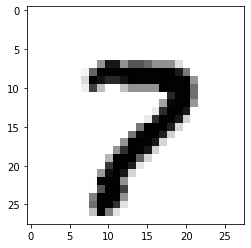

In [9]:
images, labels = next(iter(valloader))
img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

# Part 8 Testing
(This code uses real data)

Predicted Digit = 1


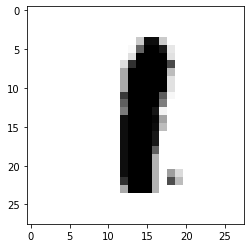

In [10]:
images, labels = next(iter(testloader))
img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

# Part 9 Confusion Matrix

In [11]:
confusion = np.zeros((10,10))
time0 = time()
for i in range(10000):
    images, labels = next(iter(testloader))
    img = images[0].view(1, 784)
    with torch.no_grad():
        logps = model(img)
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    output = probab.index(max(probab))
    actual = labels[0].tolist()
    confusion[actual][output] += 1
    if i%100 == 0:
        print('loop', i)
print((time()-time0)/60)

loop 0
loop 100
loop 200
loop 300
loop 400
loop 500
loop 600
loop 700
loop 800
loop 900
loop 1000
loop 1100
loop 1200
loop 1300
loop 1400
loop 1500
loop 1600
loop 1700
loop 1800
loop 1900
loop 2000
loop 2100
loop 2200
loop 2300
loop 2400
loop 2500
loop 2600
loop 2700
loop 2800
loop 2900
loop 3000
loop 3100
loop 3200
loop 3300
loop 3400
loop 3500
loop 3600
loop 3700
loop 3800
loop 3900
loop 4000
loop 4100
loop 4200
loop 4300
loop 4400
loop 4500
loop 4600
loop 4700
loop 4800
loop 4900
loop 5000
loop 5100
loop 5200
loop 5300
loop 5400
loop 5500
loop 5600
loop 5700
loop 5800
loop 5900
loop 6000
loop 6100
loop 6200
loop 6300
loop 6400
loop 6500
loop 6600
loop 6700
loop 6800
loop 6900
loop 7000
loop 7100
loop 7200
loop 7300
loop 7400
loop 7500
loop 7600
loop 7700
loop 7800
loop 7900
loop 8000
loop 8100
loop 8200
loop 8300
loop 8400
loop 8500
loop 8600
loop 8700
loop 8800
loop 8900
loop 9000
loop 9100
loop 9200
loop 9300
loop 9400
loop 9500
loop 9600
loop 9700
loop 9800
loop 9900
6.9215611179

In [17]:
def accuracy(confusion):
    correct = 0
    for i in range(10):
        correct += confusion[i][i]
    print('predicted correctly',correct)
    print('sum',confusion.sum())
    return correct/confusion.sum()

accuracy = accuracy(confusion)

predicted correctly 9710.0
sum 10000.0


In [18]:
def precision(confusion):
    sum = 0
    for i in range(10):
        TP = confusion[i][i]
        FP_TP = np.sum(confusion,axis=0)[i]
        precision = TP/FP_TP
        sum += precision
        #print('Precision of class ',i,' = ',precision)
    return sum/10
        
    
precision = precision(confusion)

In [19]:
def recall(confusion):
    sum = 0
    for i in range(10):
        TP = confusion[i][i]
        FN_TP = np.sum(confusion,axis=1)[i]
        recall = TP/FN_TP
        sum += recall
        #print('Recall of class ',i,' = ',recall)
    return sum/10
recall = recall(confusion)

In [21]:
def f1_score(precision,recall):
    return 2*((precision*recall) / (precision+recall))
f1_score = f1_score(precision,recall)

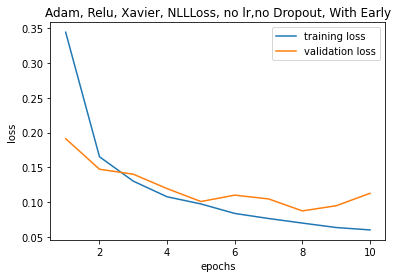

accuracy =  0.971
precision =  0.9710714188315681
recall =  0.9710316923180603
f1_score =  0.9710515551685032


In [25]:
plt.plot(x,cost,x, cost_val)
plt.title("Adam, Relu, Xavier, NLLLoss, no lr,no Dropout, With Early")
plt.legend(["training loss","validation loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

print("accuracy = ", accuracy)
print("precision = ", precision)
print("recall = ",recall)
print("f1_score = ",f1_score)

In [39]:
import plotly
import plotly.figure_factory as ff

def cm_plot(cm, labels):
    x = labels
    y = labels

    z_text = [[str(y) for y in x] for x in cm]
    fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='reds')

    fig.update_layout(title_text='Confusion Matrix (Adam, Relu, Xavier, NLLLoss, With Early)')

    fig.add_annotation(dict(font=dict(color="black",size=13),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Predicted Value",
                            xref="paper",
                            yref="paper"
                           ))

    fig.add_annotation(dict(font=dict(color="black",size=13),
                            x=-0.20,
                            y=0.5,
                            showarrow=False,
                            text="Real Value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"
                           ))

    fig.update_layout(margin=dict(t=50, l=200))
    fig['layout']['yaxis']['autorange'] = "reversed"

    fig['data'][0]['showscale'] = True
    fig.show()
    
labels = ['0','1','2','3','4','5','6','7','8','9']
cm_plot(confusion, labels)

# Test 

Predicted Hand-written Digit = 3


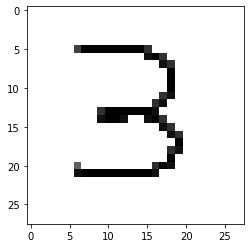

In [42]:
# Using cv2.imread() method 
# Using 0 to read image in grayscale mode 
img = cv2.imread('num3.png', 0)  # You will need to change the filename

# resize image to 28x28
img = cv2.resize(img, (28,28))

# flip the image color
# this is optional; and feel free to change it
for i in range(0,img.shape[0]):
  for j in range(0,img.shape[1]):
    if img[i,j]>125:
      img[i,j] = 0
    else:
      img[i,j] = 255 - img[i,j]

# plot the processed image
plt.imshow(img, cmap='gray_r')

# input the processed image to the network and make prediction
img = transform(img).view(1, 784)
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Hand-written Digit =", probab.index(max(probab)))